In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import model
import utils
from utils.data import TRAIN_SEQUENCE_LENGTH
from matplotlib import pyplot as plt

BATCH_SIZE = 64

device = torch.device("mps")


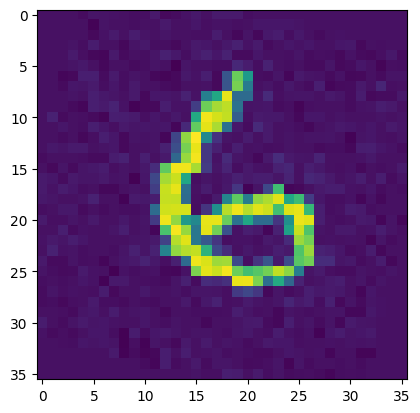

In [ ]:
transform = v2.Compose(
    [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.RandomAffine(degrees=90)]
)
data = utils.data.Datasets(
    "/Users/henrywilliams/Documents/uni/amml/assessment-2/data", transform
)
# train = DataLoader(data.n6_train(), 64)


plt.imshow(data.n6_train()[0][0].reshape(36, 36))

In [ ]:
vae = model.VAE(1, 100).to(device)

for i in range(20):
    for sequences in train:
        sequences = sequences.to(device)

        for t in range(TRAIN_SEQUENCE_LENGTH):
            

    # reconstruction, mu, logvar = vae(sequences)

torch.Size([64, 1, 36, 36])